In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from rdkit.Chem import Fragments

df1 = pd.read_csv("cardiotoxity-1.csv")
df1['tr-1'] = pd.read_csv("cardiotoxity-1.csv")['Toxicity Value']
df1['tr-5'] = pd.read_csv("cardiotoxity-5.csv")['Toxicity Value']
df1['tr-10'] = pd.read_csv("cardiotoxity-10.csv")['Toxicity Value']
df1['tr-30'] = pd.read_csv("cardiotoxity-30.csv")['Toxicity Value']
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1547 entries, 0 to 1546
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TAID              1547 non-null   object 
 1   Name              441 non-null    object 
 2   IUPAC Name        1291 non-null   object 
 3   PubChem CID       1295 non-null   float64
 4   Canonical SMILES  1547 non-null   object 
 5   InChIKey          1295 non-null   object 
 6   Toxicity Value    1547 non-null   int64  
 7   tr-1              1547 non-null   int64  
 8   tr-5              1547 non-null   int64  
 9   tr-10             1547 non-null   int64  
 10  tr-30             1547 non-null   int64  
dtypes: float64(1), int64(5), object(5)
memory usage: 133.1+ KB


<AxesSubplot:>

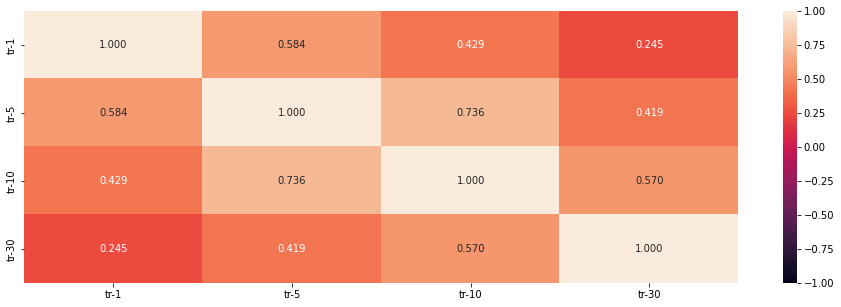

In [2]:
df1.drop(['IUPAC Name', 'PubChem CID', 'InChIKey', 'Toxicity Value'], axis=1, inplace=True)
df1 = df1.drop_duplicates(subset=['Canonical SMILES'], keep='last')
corr = df1.corr()
plt.figure(figsize = (16,5))
sns.heatmap(corr, vmax=1, vmin=-1,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True, fmt=".3f")

In [3]:
df1['allOnes'] = df1['tr-1'] + df1['tr-5'] + df1['tr-10'] + df1['tr-30']

In [4]:
df1.describe()

,tr-1,tr-5,tr-10,tr-30,allOnes
count,1545.000000,1545.000000,1545.000000,1545.000000,1545.000000
mean,0.225890,0.461489,0.612945,0.829773,2.130097
std,0.418302,0.498676,0.487234,0.375953,1.421716
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,1.000000
50%,0.000000,0.000000,1.000000,1.000000,2.000000
75%,0.000000,1.000000,1.000000,1.000000,3.000000
max,1.000000,1.000000,1.000000,1.000000,4.000000


In [5]:
df1.head(10)


,TAID,Name,Canonical SMILES,tr-1,tr-5,tr-10,tr-30,allOnes
0,TOX-74,NaN,S=c1nc[nH]c2nc[nH]c12,0,0,1,1,2
1,TOX-81,NaN,[NH3+][C@@H](CC(=O)N1CCn2c(nnc2C(F)(F)F)C1)Cc1...,0,0,0,0,0
2,TOX-102,lamotrigine,Nc1nnc(-c2cccc(Cl)c2Cl)c(N)n1,0,0,0,0,0
3,TOX-125,Ezetimibe,O=C1[C@H](CC[C@H](O)c2ccc(F)cc2)[C@@H](c2ccc(O...,0,0,0,1,1
4,TOX-133,Keoxifene,O=C(c1ccc(OCC[NH+]2CCCCC2)cc1)c1c(-c2ccc(O)cc2...,0,0,0,1,1
5,TOX-162,riluzole,Nc1nc2ccc(OC(F)(F)F)cc2s1,0,0,0,1,1
6,TOX-163,cilostazol,O=C1CCc2cc(OCCCCc3nnnn3C3CCCCC3)ccc2N1,1,1,1,1,4
7,TOX-174,NaN,[NH3+]CC1(CC(=O)[O-])CCCCC1,0,0,0,0,0
8,TOX-181,NaN,NC(=O)C(c1ccccc1)(c1ccccc1)[C@@H]1CC[NH+](CCc2...,1,1,1,1,4
9,TOX-183,clotrimazole,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,0,1,1,1,3


In [6]:
df2 = pd.read_table('cardiotoxity-regression.txt', sep='\t')
df2.head()

,SAMPLE_ID,SAMPLE_DATA_ID,PROTOCOL_NAME,SAMPLE_DATA_TYPE,ASSAY_OUTCOME,CURVE_CLASS2,AC50,EFFICACY,ZERO_ACTIVITY,INF_ACTIVITY,...,CAS,PUBCHEM_CID,PUBCHEM_SID,PURITY_RATING,PURITY_RATING_4M,SAMPLE_NAME,SMILES,TOX21_ID,PURITY,Unnamed: 55
0,NCGC00255163-01,243694629,tox21-herg-u2os-p1,set1,NaN,4.0,0.691666,-7.041105,3.000000,-4.041105,...,71-23-8,1031.0,144212757,A,Ac,1-Propanol,CCCO,Tox21_302440,NaN,NaN
1,NCGC00257537-01,243694636,tox21-herg-u2os-p1,set1,NaN,4.0,NaN,0.000000,0.000000,0.000000,...,640-19-7,12542.0,144211614,A,A,2-Fluoroacetamide,FCC(N)=O,Tox21_301297,NaN,NaN
2,NCGC00258978-01,243698196,tox21-herg-u2os-p1,set1,NaN,4.0,NaN,0.000000,0.000000,0.000000,...,106-93-4,7839.0,144208625,AC,F,"1,2-Dibromoethane",BrCCBr,Tox21_201427,NaN,NaN
3,NCGC00259980-01,243698197,tox21-herg-u2os-p1,set1,NaN,4.0,NaN,0.000000,0.000000,0.000000,...,627-03-2,12301.0,144209629,A,A,Ethoxyacetic acid,O=C(O)COCC,Tox21_202431,NaN,NaN
4,NCGC00259084-01,243698200,tox21-herg-u2os-p1,set1,NaN,4.0,2.533001,6.038564,-1.538564,4.500000,...,756-79-6,12958.0,144208732,A,Ac,Dimethyl methylphosphonate,CP(=O)(OC)OC,Tox21_201534,NaN,NaN


In [7]:
df2['AC50'] = df2['AC50'].fillna(0)
df2.describe()

,SAMPLE_DATA_ID,ASSAY_OUTCOME,CURVE_CLASS2,AC50,EFFICACY,ZERO_ACTIVITY,INF_ACTIVITY,HILL_COEF,R2,P_HILL,...,CONC10,CONC11,CONC12,CONC13,CONC14,CONC15,PUBCHEM_CID,PUBCHEM_SID,PURITY,Unnamed: 55
count,3.335400e+04,0.0,33354.000000,33354.000000,33336.000000,33336.000000,33336.000000,14493.000000,14493.000000,14500.000000,...,3.335400e+04,3.335400e+04,3.335400e+04,3.335400e+04,3.194600e+04,0.0,3.292200e+04,3.335400e+04,0.0,0.0
mean,2.437163e+08,NaN,3.106839,8.933008,-9.015239,-0.022833,-9.038073,2.996375,0.680513,0.113425,...,2.968878e-06,6.638705e-06,1.484602e-05,3.319226e-05,6.990359e-05,NaN,2.584249e+06,1.530006e+08,NaN,NaN
std,1.573908e+04,NaN,2.126282,18.513233,25.820883,3.273379,25.482049,1.593897,0.228873,0.128467,...,1.459510e-05,3.264665e-05,7.299444e-05,1.632333e-04,3.723828e-04,NaN,9.176075e+06,2.076752e+07,NaN,NaN
min,2.436892e+08,NaN,-3.000000,0.000000,-183.888768,-127.816972,-184.752711,0.200000,0.300186,0.000000,...,1.149000e-08,2.570000e-08,5.747000e-08,1.285000e-07,2.874000e-07,NaN,4.000000e+00,1.442055e+08,NaN,NaN
25%,2.436985e+08,NaN,4.000000,0.000000,-8.867665,0.000000,-4.168976,1.538589,0.460197,0.000174,...,1.757000e-06,3.929000e-06,8.785000e-06,1.964000e-05,3.831000e-05,NaN,7.451250e+03,1.442097e+08,NaN,NaN
50%,2.437214e+08,NaN,4.000000,0.000000,0.000000,0.000000,0.000000,2.720221,0.684525,0.050205,...,3.065000e-06,6.854000e-06,1.533000e-05,3.427000e-05,7.663000e-05,NaN,1.710900e+04,1.442125e+08,NaN,NaN
75%,2.437297e+08,NaN,4.000000,10.682196,0.000000,0.000000,0.000000,4.954917,0.914507,0.224937,...,3.065000e-06,6.854000e-06,1.533000e-05,3.427000e-05,7.663000e-05,NaN,9.283900e+04,1.442140e+08,NaN,NaN
max,2.437381e+08,NaN,5.000000,1000.000000,237.556333,31.503031,236.432959,4.954917,0.998993,0.931265,...,1.537000e-03,3.438000e-03,7.687000e-03,1.719000e-02,3.844000e-02,NaN,9.175953e+07,2.519200e+08,NaN,NaN


In [8]:
df2 = df2.loc[:, ~df2.columns.str.contains('^Unnamed')]
df2 = df2.loc[:, ~df2.columns.str.contains('^DATA')]
df2 = df2.loc[:, ~df2.columns.str.contains('^CONC')]
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33354 entries, 0 to 33353
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SAMPLE_ID         33354 non-null  object 
 1   SAMPLE_DATA_ID    33354 non-null  int64  
 2   PROTOCOL_NAME     33354 non-null  object 
 3   SAMPLE_DATA_TYPE  33354 non-null  object 
 4   ASSAY_OUTCOME     0 non-null      float64
 5   CURVE_CLASS2      33354 non-null  float64
 6   AC50              33354 non-null  float64
 7   EFFICACY          33336 non-null  float64
 8   ZERO_ACTIVITY     33336 non-null  float64
 9   INF_ACTIVITY      33336 non-null  float64
 10  HILL_COEF         14493 non-null  float64
 11  R2                14493 non-null  float64
 12  P_HILL            14500 non-null  float64
 13  CHANNEL_OUTCOME   0 non-null      float64
 14  CAS               33354 non-null  object 
 15  PUBCHEM_CID       32922 non-null  float64
 16  PUBCHEM_SID       33354 non-null  int64 

In [9]:
df2.head()

,SAMPLE_ID,SAMPLE_DATA_ID,PROTOCOL_NAME,SAMPLE_DATA_TYPE,ASSAY_OUTCOME,CURVE_CLASS2,AC50,EFFICACY,ZERO_ACTIVITY,INF_ACTIVITY,...,CHANNEL_OUTCOME,CAS,PUBCHEM_CID,PUBCHEM_SID,PURITY_RATING,PURITY_RATING_4M,SAMPLE_NAME,SMILES,TOX21_ID,PURITY
0,NCGC00255163-01,243694629,tox21-herg-u2os-p1,set1,NaN,4.0,0.691666,-7.041105,3.000000,-4.041105,...,NaN,71-23-8,1031.0,144212757,A,Ac,1-Propanol,CCCO,Tox21_302440,NaN
1,NCGC00257537-01,243694636,tox21-herg-u2os-p1,set1,NaN,4.0,0.000000,0.000000,0.000000,0.000000,...,NaN,640-19-7,12542.0,144211614,A,A,2-Fluoroacetamide,FCC(N)=O,Tox21_301297,NaN
2,NCGC00258978-01,243698196,tox21-herg-u2os-p1,set1,NaN,4.0,0.000000,0.000000,0.000000,0.000000,...,NaN,106-93-4,7839.0,144208625,AC,F,"1,2-Dibromoethane",BrCCBr,Tox21_201427,NaN
3,NCGC00259980-01,243698197,tox21-herg-u2os-p1,set1,NaN,4.0,0.000000,0.000000,0.000000,0.000000,...,NaN,627-03-2,12301.0,144209629,A,A,Ethoxyacetic acid,O=C(O)COCC,Tox21_202431,NaN
4,NCGC00259084-01,243698200,tox21-herg-u2os-p1,set1,NaN,4.0,2.533001,6.038564,-1.538564,4.500000,...,NaN,756-79-6,12958.0,144208732,A,Ac,Dimethyl methylphosphonate,CP(=O)(OC)OC,Tox21_201534,NaN


In [10]:
df2.apply(pd.unique)

SAMPLE_ID           [NCGC00255163-01, NCGC00257537-01, NCGC0025897...
SAMPLE_DATA_ID      [243694629, 243694636, 243698196, 243698197, 2...
PROTOCOL_NAME                                    [tox21-herg-u2os-p1]
SAMPLE_DATA_TYPE                                   [set1, set3, set2]
ASSAY_OUTCOME                                                   [nan]
CURVE_CLASS2        [4.0, -2.4, -2.2, -3.0, 2.1, -2.1, 2.4, 3.0, -...
AC50                [0.6916661927, 0.0, 2.5330010202, 17.373869244...
EFFICACY            [-7.041105484, 0.0, 6.0385644999, 10.489420199...
ZERO_ACTIVITY       [3.0, 0.0, -1.5385644999, -2.9894201999, -2.29...
INF_ACTIVITY        [-4.041105484, 0.0, 4.5, 7.5, 3.5, -34.9100650...
HILL_COEF           [1.031, nan, 2.09374246, 0.7999999998999999, 4...
R2                  [0.6088608256, nan, 0.3576804738, 0.3820917992...
P_HILL              [0.105621886, nan, 0.3300341797, 0.290223847, ...
CHANNEL_OUTCOME                                                 [nan]
CAS                 

In [11]:
df2 = df2[['SMILES', 'AC50']]
df2 = df2.drop_duplicates(subset=['SMILES'], keep='last')
df2 = df2.dropna()
df2.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7690 entries, 1209 to 33353
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SMILES  7690 non-null   object 
 1   AC50    7690 non-null   float64
dtypes: float64(1), object(1)
memory usage: 180.2+ KB


In [12]:
matches = df1['Canonical SMILES'].isin(df2['SMILES'])
matches.sum()

1

In [13]:
matches = df2['SMILES'].isin(df1['Canonical SMILES'])
matches.sum()

1

In [14]:
data_from_df1 = df1[['Canonical SMILES', 'tr-30']]
data_from_df1 = data_from_df1.rename(columns={"Canonical SMILES": 'SMILES', "tr-30": "bloker"})
data_from_df1.head(10)

,SMILES,bloker
0,S=c1nc[nH]c2nc[nH]c12,1
1,[NH3+][C@@H](CC(=O)N1CCn2c(nnc2C(F)(F)F)C1)Cc1...,0
2,Nc1nnc(-c2cccc(Cl)c2Cl)c(N)n1,0
3,O=C1[C@H](CC[C@H](O)c2ccc(F)cc2)[C@@H](c2ccc(O...,1
4,O=C(c1ccc(OCC[NH+]2CCCCC2)cc1)c1c(-c2ccc(O)cc2...,1
5,Nc1nc2ccc(OC(F)(F)F)cc2s1,1
6,O=C1CCc2cc(OCCCCc3nnnn3C3CCCCC3)ccc2N1,1
7,[NH3+]CC1(CC(=O)[O-])CCCCC1,0
8,NC(=O)C(c1ccccc1)(c1ccccc1)[C@@H]1CC[NH+](CCc2...,1
9,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,1


In [15]:
from rdkit import Chem 
data_from_df1['molecula'] = data_from_df1['SMILES'].apply(lambda x: Chem.MolFromSmiles(x)) 
data_from_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1545 entries, 0 to 1546
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   SMILES    1545 non-null   object
 1   bloker    1545 non-null   int64 
 2   molecula  1545 non-null   object
dtypes: int64(1), object(2)
memory usage: 48.3+ KB


In [16]:
data_from_df1.isna().sum()

SMILES      0
bloker      0
molecula    0
dtype: int64

In [17]:
df2['molecula'] = df2['SMILES'].apply(lambda x: Chem.MolFromSmiles(x)) 

RDKit ERROR: [17:47:28] Can't kekulize mol.  Unkekulized atoms: 2 3 4 6 7
RDKit ERROR: 
RDKit ERROR: [17:47:28] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 16
RDKit ERROR: 
RDKit ERROR: [17:47:28] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
RDKit ERROR: 
RDKit ERROR: [17:47:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
RDKit ERROR: 
RDKit ERROR: [17:47:28] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
RDKit ERROR: 
RDKit ERROR: [17:47:28] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 32 33 34 35 36 37 38 39
RDKit ERROR: 
RDKit ERROR: [17:47:28] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [17:47:28] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
RDKit ERROR: 
RDKit ERROR: [17:47:28] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5 6 8 9 10
RDKit ERROR: 
RDKit ERROR: [17:47:28] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17 18 19 20 21
RDKit ERROR: 
RDKit ERROR: [17:47:28] Can

In [18]:
df2.isna().sum()

SMILES        0
AC50          0
molecula    166
dtype: int64

In [19]:
data = df2.dropna()
data.head()

,SMILES,AC50,molecula
1209,Cl.CN3CCCN=C3COC(=O)C(O)(c1ccccc1)C2CCCCC2,4.771562,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d0d0>
1767,[K+].FC(F)(C(F)(F)S([O-])(=O)=O)C(F)(F)C(F)(F)...,0.000000,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d3f0>
2307,Clc1ccc(cc1Cl)C(=O)NC(CCC(=O)O)C(=O)N(CCCCC)CCCOC,0.000000,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d300>
2629,ON=CC=NO,0.000000,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d440>
2657,CN(C)CCOC(=O)c1cc3c(cc1)n(Cc2ccccc2)c(C)c3C,6.007040,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d490>


In [20]:
data['bloker'] = data['AC50'].apply(lambda x: 0 if x < 30 else 1)

data = data.drop(['AC50'], axis=1)

data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,SMILES,molecula,bloker
1209,Cl.CN3CCCN=C3COC(=O)C(O)(c1ccccc1)C2CCCCC2,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d0d0>,0
1767,[K+].FC(F)(C(F)(F)S([O-])(=O)=O)C(F)(F)C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d3f0>,0
2307,Clc1ccc(cc1Cl)C(=O)NC(CCC(=O)O)C(=O)N(CCCCC)CCCOC,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d300>,0
2629,ON=CC=NO,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d440>,0
2657,CN(C)CCOC(=O)c1cc3c(cc1)n(Cc2ccccc2)c(C)c3C,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d490>,0


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7524 entries, 1209 to 33353
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   SMILES    7524 non-null   object
 1   molecula  7524 non-null   object
 2   bloker    7524 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 235.1+ KB


In [22]:
data_from_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1545 entries, 0 to 1546
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   SMILES    1545 non-null   object
 1   bloker    1545 non-null   int64 
 2   molecula  1545 non-null   object
dtypes: int64(1), object(2)
memory usage: 48.3+ KB


In [23]:
data = data.append(data_from_df1, ignore_index = True)  
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9069 entries, 0 to 9068
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   SMILES    9069 non-null   object
 1   molecula  9069 non-null   object
 2   bloker    9069 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 212.7+ KB


In [24]:
data.drop_duplicates(subset=['SMILES'], keep='last', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9068 entries, 0 to 9068
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   SMILES    9068 non-null   object
 1   molecula  9068 non-null   object
 2   bloker    9068 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 283.4+ KB


In [25]:
data['num_of_atoms'] = data['molecula'].apply(lambda x: x.GetNumAtoms())
data['num_of_heavy_atoms'] = data['molecula'].apply(lambda x: x.GetNumHeavyAtoms())

In [26]:
data.head()

,SMILES,molecula,bloker,num_of_atoms,num_of_heavy_atoms
0,Cl.CN3CCCN=C3COC(=O)C(O)(c1ccccc1)C2CCCCC2,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d0d0>,0,26,26
1,[K+].FC(F)(C(F)(F)S([O-])(=O)=O)C(F)(F)C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d3f0>,0,24,24
2,Clc1ccc(cc1Cl)C(=O)NC(CCC(=O)O)C(=O)N(CCCCC)CCCOC,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d300>,0,30,30
3,ON=CC=NO,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d440>,0,6,6
4,CN(C)CCOC(=O)c1cc3c(cc1)n(Cc2ccccc2)c(C)c3C,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d490>,0,26,26


In [27]:
def number_of_atoms(atom_list, df):
    for i in atom_list:
        df['num_of_{}_atoms'.format(i)] = df['molecula'].apply(lambda x: len(x.GetSubstructMatches(Chem.MolFromSmiles(i))))

number_of_atoms(['C','O', 'N', 'Cl', 'Br', 'P'], data)

In [28]:
data.head()


,SMILES,molecula,bloker,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_Br_atoms,num_of_P_atoms
0,Cl.CN3CCCN=C3COC(=O)C(O)(c1ccccc1)C2CCCCC2,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d0d0>,0,26,26,20,3,2,1,0,0
1,[K+].FC(F)(C(F)(F)S([O-])(=O)=O)C(F)(F)C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d3f0>,0,24,24,6,3,0,0,0,0
2,Clc1ccc(cc1Cl)C(=O)NC(CCC(=O)O)C(=O)N(CCCCC)CCCOC,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d300>,0,30,30,21,5,2,2,0,0
3,ON=CC=NO,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d440>,0,6,6,2,2,2,0,0,0
4,CN(C)CCOC(=O)c1cc3c(cc1)n(Cc2ccccc2)c(C)c3C,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d490>,0,26,26,22,2,2,0,0,0


In [29]:
from rdkit.Chem import Descriptors
data['mol_weight'] = data['molecula'].apply(lambda x: Descriptors.MolWt(x))
data.head()

,SMILES,molecula,bloker,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_Br_atoms,num_of_P_atoms,mol_weight
0,Cl.CN3CCCN=C3COC(=O)C(O)(c1ccccc1)C2CCCCC2,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d0d0>,0,26,26,20,3,2,1,0,0,380.916
1,[K+].FC(F)(C(F)(F)S([O-])(=O)=O)C(F)(F)C(F)(F)...,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d3f0>,0,24,24,6,3,0,0,0,0,438.202
2,Clc1ccc(cc1Cl)C(=O)NC(CCC(=O)O)C(=O)N(CCCCC)CCCOC,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d300>,0,30,30,21,5,2,2,0,0,461.386
3,ON=CC=NO,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d440>,0,6,6,2,2,2,0,0,0,88.066
4,CN(C)CCOC(=O)c1cc3c(cc1)n(Cc2ccccc2)c(C)c3C,<rdkit.Chem.rdchem.Mol object at 0x7fcb0490d490>,0,26,26,22,2,2,0,0,0,350.462


<AxesSubplot:>

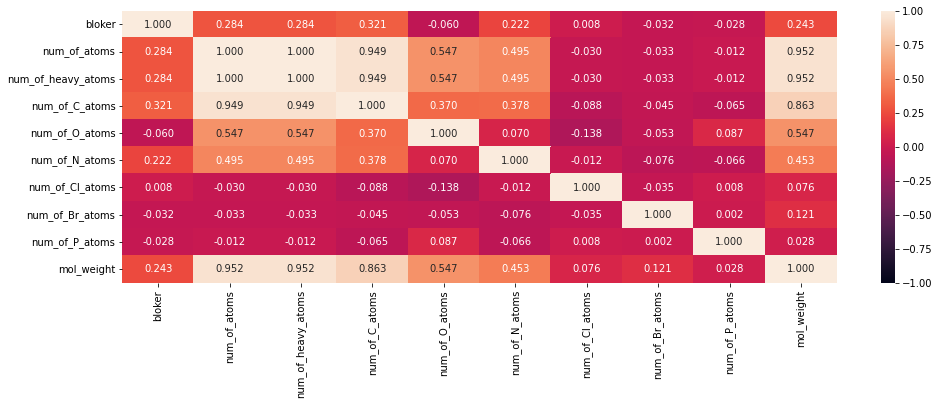

In [30]:
corr = data.corr()
plt.figure(figsize = (16,5))
sns.heatmap(corr, vmax=1, vmin=-1,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True, fmt=".3f")

In [31]:
data['mol_w'] = data['molecula'].apply(lambda x: Descriptors.ExactMolWt(x))
data['num_valence_electrons'] = data['molecula'].apply(lambda x: Descriptors.NumValenceElectrons(x))
data['num_heteroatoms'] = data['molecula'].apply(lambda x: Descriptors.NumHeteroatoms(x))
data['tpsa'] = data['molecula'].apply(lambda x: Descriptors.TPSA(x))
from rdkit.Chem import Crippen
data['clogp']= data['molecula'].apply(lambda x: Crippen.MolLogP(x))
data['clogmr']= data['molecula'].apply(lambda x: Crippen.MolMR(x))

data['fr_benzene'] = data['molecula'].apply(Fragments.fr_benzene)


In [32]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

# model = word2vec.Word2Vec.load('model_300dim.pkl')
data['sentence'] = data.apply(lambda x: MolSentence(mol2alt_sentence(x['molecula'], 1)), axis=1)
# data['mol2vec'] = [DfVec(x) for x in sentences2vec(data['sentence'], model, unseen='UNK')]
# data['vec'] = data['mol2vec'].vec
data.head()

,SMILES,molecula,bloker,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_Br_atoms,num_of_P_atoms,mol_weight,mol_w,num_valence_electrons,num_heteroatoms,tpsa,clogp,clogmr,fr_benzene,sentence
0,Cl.CN3CCCN=C3COC(=O)C(O)(c1ccccc1)C2CCCCC2,"<img data-content=""rdkit/molecule"" src=""data:i...",0,26,26,20,3,2,1,0,0,380.916,380.186670,144,6,62.13,3.15350,104.6698,1,"(1016845826, 2246728737, 3657471097, 209248963..."
1,[K+].FC(F)(C(F)(F)S([O-])(=O)=O)C(F)(F)C(F)(F)...,"<img data-content=""rdkit/molecule"" src=""data:i...",0,24,24,6,3,0,0,0,0,438.202,437.899763,140,18,57.20,0.23190,40.4872,0,"(3892129619, 882399112, 485463469, 2245277810,..."
2,Clc1ccc(cc1Cl)C(=O)NC(CCC(=O)O)C(=O)N(CCCCC)CCCOC,"<img data-content=""rdkit/molecule"" src=""data:i...",0,30,30,21,5,2,2,0,0,461.386,460.153177,168,9,95.94,4.01190,117.1840,1,"(1016841875, 3452535345, 3217380708, 242497367..."
3,ON=CC=NO,"<img data-content=""rdkit/molecule"" src=""data:i...",0,6,6,2,2,2,0,0,0,88.066,88.027277,34,4,65.18,-0.09360,20.5570,0,"(864662311, 2328129879, 847336149, 2477902888,..."
4,CN(C)CCOC(=O)c1cc3c(cc1)n(Cc2ccccc2)c(C)c3C,"<img data-content=""rdkit/molecule"" src=""data:i...",0,26,26,22,2,2,0,0,0,350.462,350.199428,136,4,34.47,4.02484,105.7925,2,"(2246728737, 3818546315, 848128881, 3121777292..."


In [33]:
data['sentence_len'] = data['sentence'].apply(len)
data = data.drop(['sentence', 'SMILES'], axis=1)
data.head()

,molecula,bloker,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_Br_atoms,num_of_P_atoms,mol_weight,mol_w,num_valence_electrons,num_heteroatoms,tpsa,clogp,clogmr,fr_benzene,sentence_len
0,"<img data-content=""rdkit/molecule"" src=""data:i...",0,26,26,20,3,2,1,0,0,380.916,380.186670,144,6,62.13,3.15350,104.6698,1,51
1,"<img data-content=""rdkit/molecule"" src=""data:i...",0,24,24,6,3,0,0,0,0,438.202,437.899763,140,18,57.20,0.23190,40.4872,0,47
2,"<img data-content=""rdkit/molecule"" src=""data:i...",0,30,30,21,5,2,2,0,0,461.386,460.153177,168,9,95.94,4.01190,117.1840,1,60
3,"<img data-content=""rdkit/molecule"" src=""data:i...",0,6,6,2,2,2,0,0,0,88.066,88.027277,34,4,65.18,-0.09360,20.5570,0,12
4,"<img data-content=""rdkit/molecule"" src=""data:i...",0,26,26,22,2,2,0,0,0,350.462,350.199428,136,4,34.47,4.02484,105.7925,2,52


<AxesSubplot:>

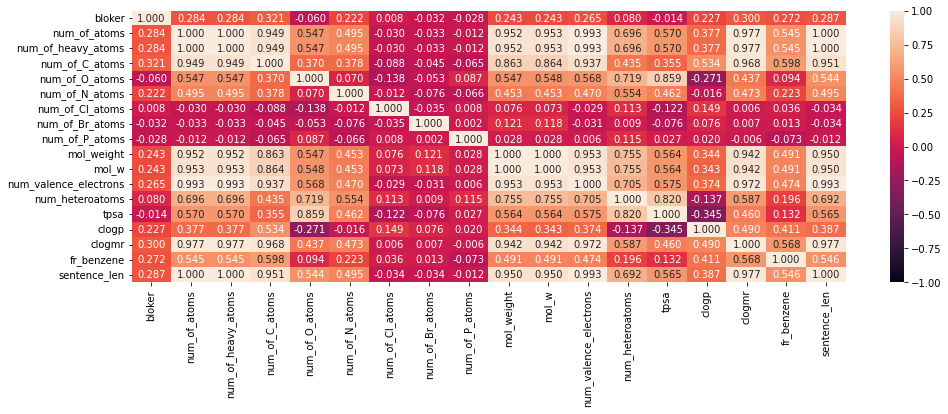

In [34]:
data = data.drop(['molecula'], axis=1)

corr = data.corr()
plt.figure(figsize = (16,5))
sns.heatmap(corr, vmax=1, vmin=-1,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True, fmt=".3f")

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC

RANDOM_STATE = np.random.RandomState(1000)
TARGET = 'bloker'
def get_features(data, scaler = None):
    result = data.drop([TARGET], axis=1)
    if scaler is not None:
        result = scaler.transform(result)
    return result

def get_model_and_scaler_with_RMSE(data):
    target = data[TARGET]
    features = get_features(data)
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.20, random_state=RANDOM_STATE)
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)
    linear_regression = SVC(random_state=RANDOM_STATE, probability=True)
    linear_regression.fit(features_train, target_train)

    predictions_valid = linear_regression.predict_proba(features_valid)[:, 1]
    err = roc_auc_score(target_valid, predictions_valid)
    print(f"ROC AUC модели: {err:.2f}")
    return linear_regression, scaler

model, scaler = get_model_and_scaler_with_RMSE(data)

ROC AUC модели: 0.75


In [36]:
data['pred'] = model.predict(get_features(data, scaler))
data.describe()

,bloker,num_of_atoms,num_of_heavy_atoms,num_of_C_atoms,num_of_O_atoms,num_of_N_atoms,num_of_Cl_atoms,num_of_Br_atoms,num_of_P_atoms,mol_weight,mol_w,num_valence_electrons,num_heteroatoms,tpsa,clogp,clogmr,fr_benzene,sentence_len,pred
count,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000,9068.000000
mean,0.225408,19.266762,19.266652,14.176555,2.523379,1.475518,0.363586,0.053595,0.030768,287.129128,286.706255,104.387406,5.090097,56.348163,2.385824,74.945479,0.944199,38.377812,0.099581
std,0.417874,10.163914,10.164063,8.098655,2.443856,1.633294,0.866790,0.372774,0.187986,147.168142,146.997586,54.073303,3.558634,47.225531,2.449713,38.091187,0.948536,20.306262,0.299457
min,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.026000,30.010565,8.000000,0.000000,0.000000,-30.816400,0.000000,0.000000,2.000000,0.000000
25%,0.000000,11.000000,11.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,174.196000,174.036305,64.000000,3.000000,26.300000,1.198400,45.297625,0.000000,22.000000,0.000000
50%,0.000000,17.000000,17.000000,13.000000,2.000000,1.000000,0.000000,0.000000,0.000000,264.325000,263.951254,94.000000,4.000000,46.530000,2.519900,69.122200,1.000000,34.000000,0.000000
75%,0.000000,25.000000,25.000000,20.000000,4.000000,2.000000,0.000000,0.000000,0.000000,372.230250,371.233005,136.000000,7.000000,75.745000,3.821605,97.761500,2.000000,50.000000,0.000000
max,1.000000,122.000000,122.000000,76.000000,46.000000,14.000000,12.000000,10.000000,3.000000,1701.206000,1700.172974,632.000000,49.000000,777.980000,15.879200,382.802000,10.000000,244.000000,1.000000


In [37]:
data[['bloker', 'pred']].head(100)

,bloker,pred
0,0,0
1,0,0
2,0,0
3,0,0
4,0,1
...,...,...
95,0,0
96,0,0
97,0,0
98,0,0


In [38]:
data.apply(pd.unique)

bloker                                                              [0, 1]
num_of_atoms             [26, 24, 30, 6, 15, 10, 34, 23, 22, 9, 31, 52,...
num_of_heavy_atoms       [26, 24, 30, 6, 15, 10, 34, 23, 22, 9, 31, 52,...
num_of_C_atoms           [20, 6, 21, 2, 22, 12, 13, 7, 30, 17, 14, 8, 4...
num_of_O_atoms           [3, 5, 2, 1, 4, 6, 0, 8, 7, 9, 12, 13, 40, 10,...
num_of_N_atoms              [2, 0, 5, 3, 1, 4, 6, 14, 7, 10, 9, 8, 12, 11]
num_of_Cl_atoms                        [1, 0, 2, 3, 6, 5, 4, 7, 8, 12, 10]
num_of_Br_atoms                               [0, 1, 2, 4, 3, 8, 6, 5, 10]
num_of_P_atoms                                                [0, 1, 2, 3]
mol_weight               [380.9160000000002, 438.202, 461.3860000000004...
mol_w                    [380.186670468, 437.8997634, 460.1531774199999...
num_valence_electrons    [144, 140, 168, 34, 136, 126, 74, 52, 170, 128...
num_heteroatoms          [6, 18, 9, 4, 12, 2, 3, 8, 11, 1, 0, 7, 5, 15,...
tpsa                     